In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
from scipy import stats

from geo_structs import Restaurant


## Data Preparation

In [2]:
data_dir = Path("outputs/500m_radius")
data_files = list(data_dir.glob("*.json"))

data_rows = []

for data_file in data_files:
    location_name = data_file.stem
    restaurants_data = json.loads(data_file.read_text())
    for restaurant in restaurants_data:
        location_data = Restaurant.model_validate(restaurant)
        row = location_data.model_dump()
        row["workarea"] = location_name
        data_rows.append(row)

df = pd.DataFrame(data_rows)


## Filter out restaurants with too-little ratings

In [3]:
filtered_df = df[df["userRatingCount"] >= 25]

## Prepare a function for weighted scores

In [4]:
def compute_adjusted_score_within_workarea(group):
    min_dist = group["distance_to_center"].min()
    max_dist = group["distance_to_center"].max()
    
    # Avoid division by zero if all distances are equal
    if max_dist == min_dist:
        distance_weight = 1.0
    else:
        distance_weight = 1 - (group["distance_to_center"] - min_dist) / (max_dist - min_dist)
    
    group["adjusted_score"] = group["rating"] * distance_weight
    return group

## Compare food quality across all workareas

In [6]:
avg_rating_per_workplace = filtered_df.groupby("workarea")["rating"].mean().reset_index()
avg_rating_per_workplace = avg_rating_per_workplace.sort_values("rating", ascending=False)

C:\Users\Bulgarit\AppData\Local\Temp\ipykernel_3556\3392975594.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


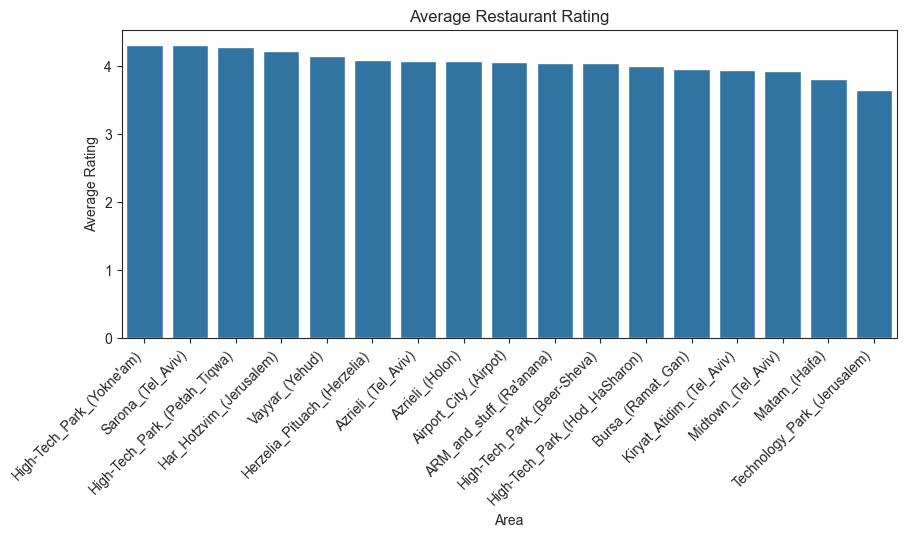

In [7]:
sns.set_style("ticks")
plt.figure(figsize=(10, 4))
ax = sns.barplot(x='workarea', y='rating', data=avg_rating_per_workplace)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.title('Average Restaurant Rating')
plt.xlabel('Area')
plt.ylabel('Average Rating')
plt.show()

## Compare individual workplaces

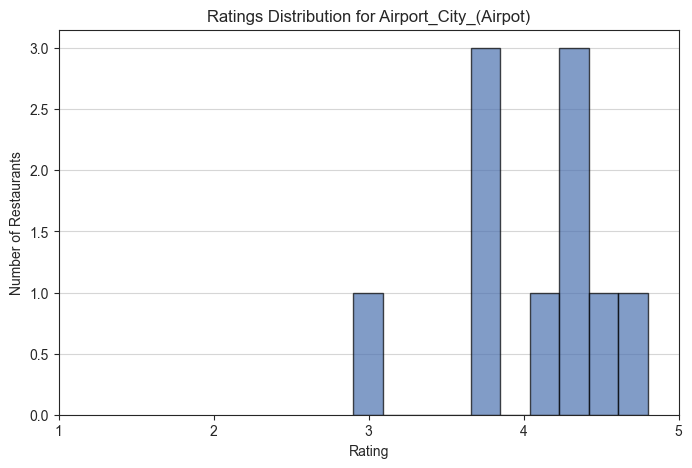

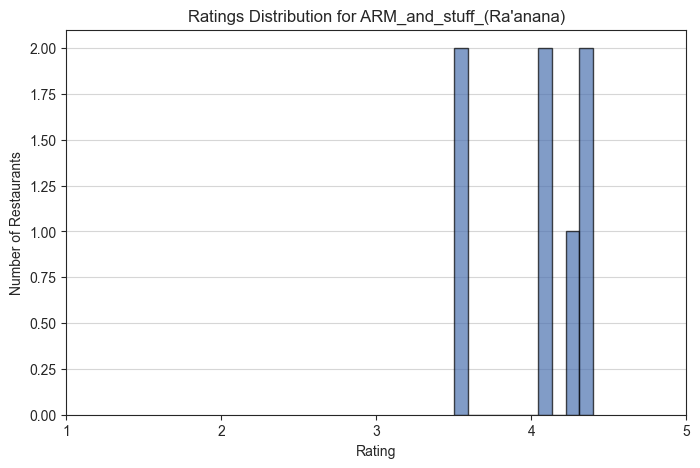

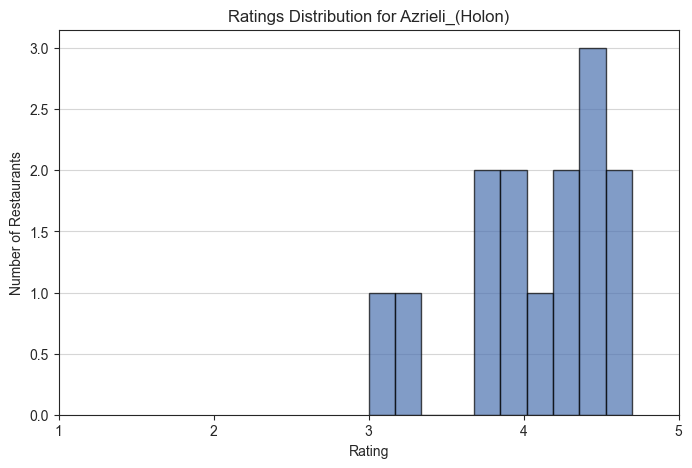

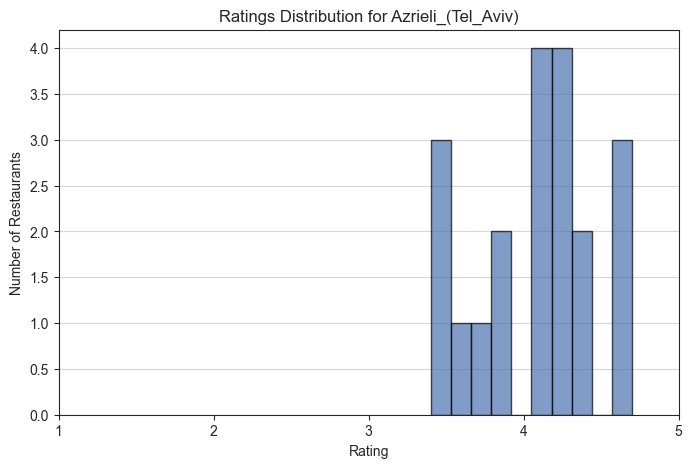

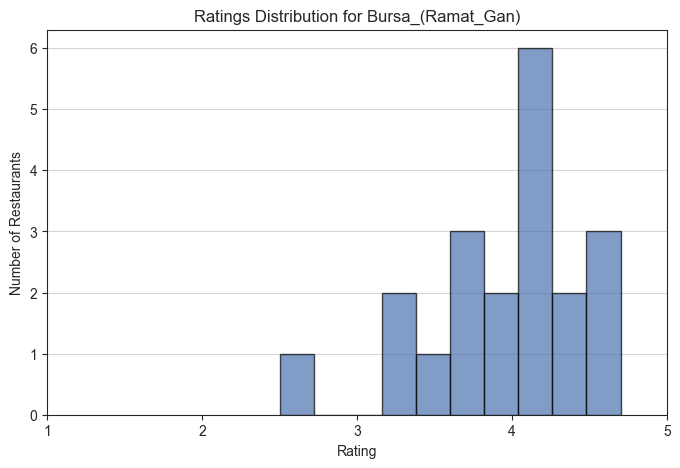

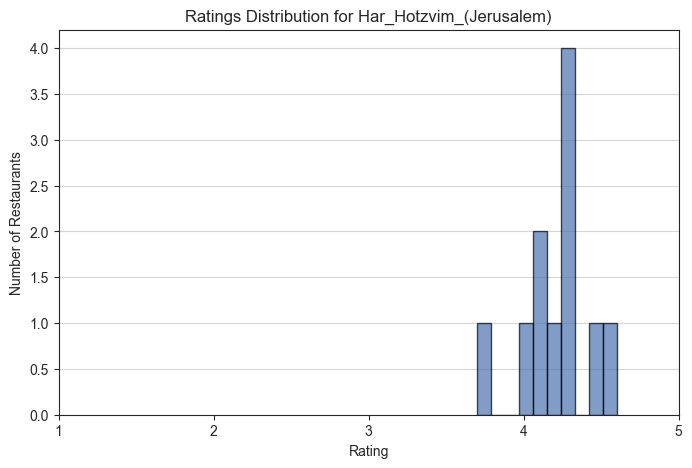

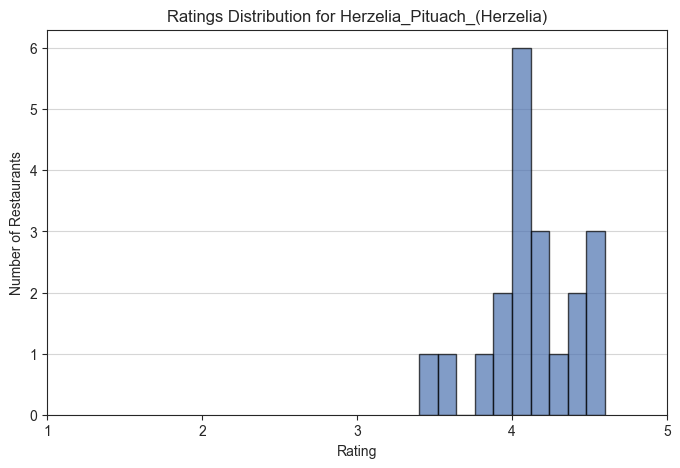

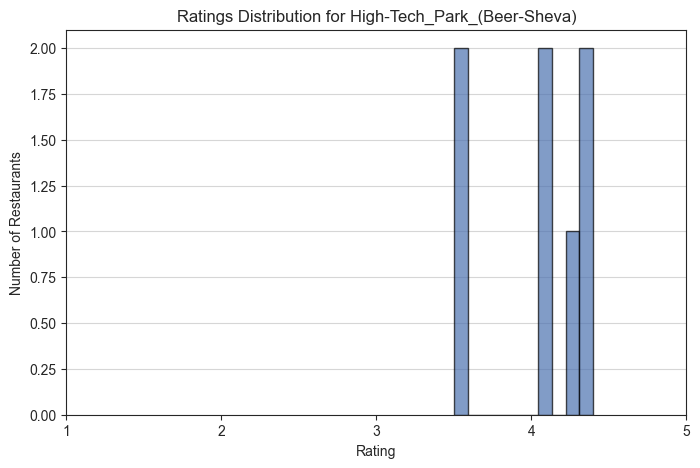

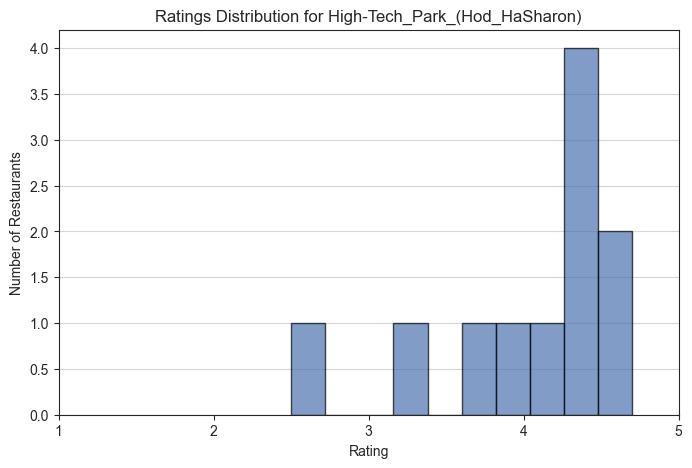

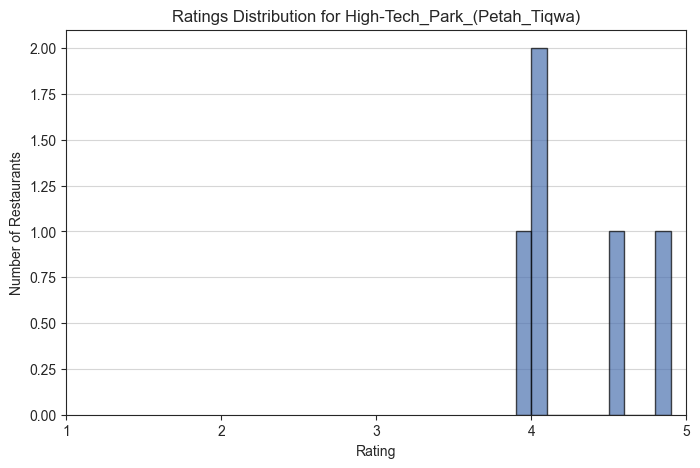

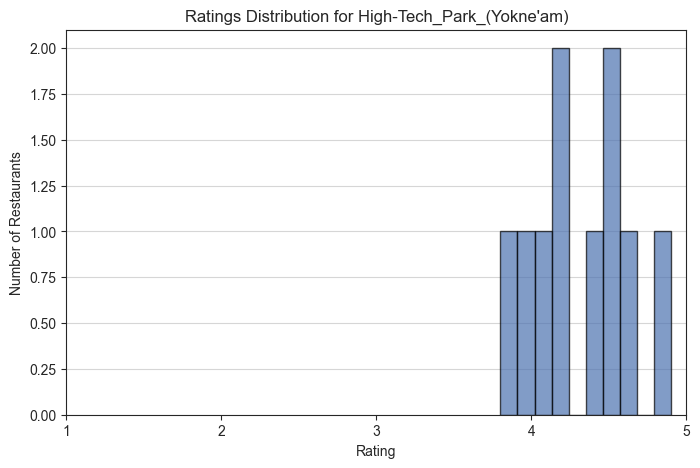

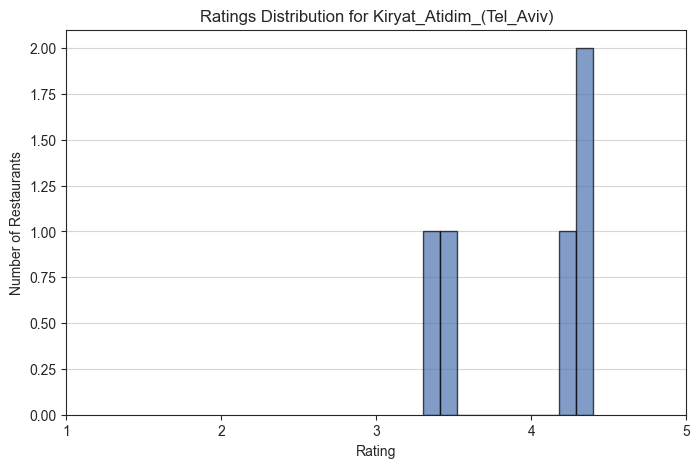

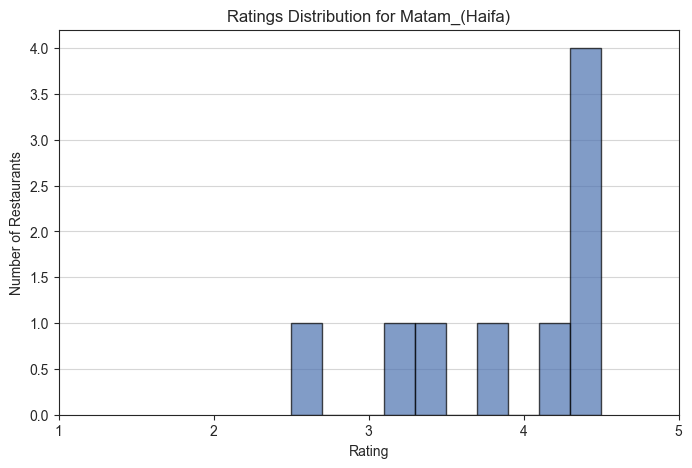

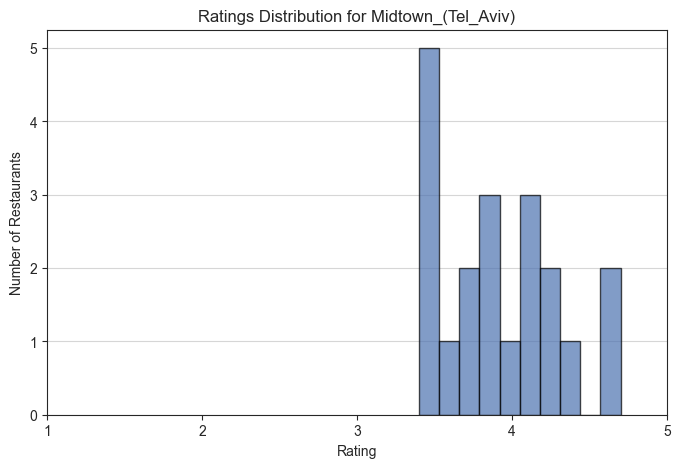

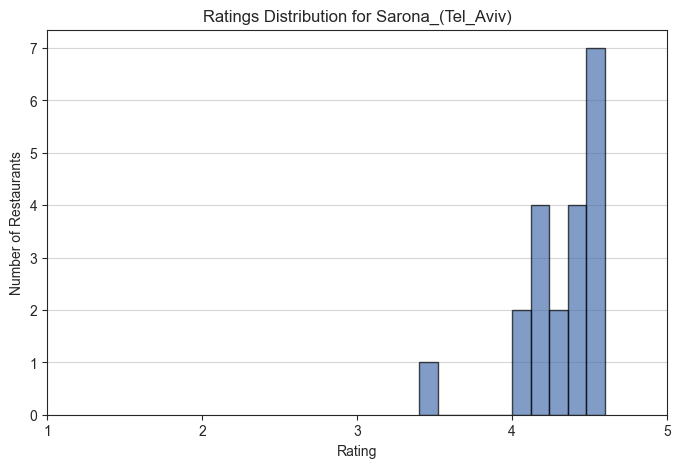

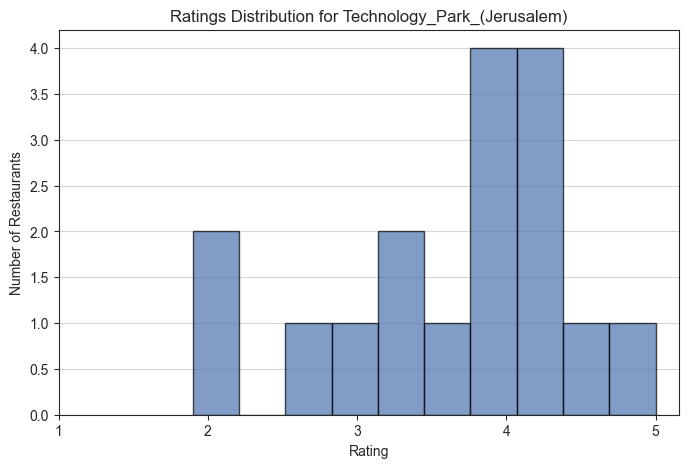

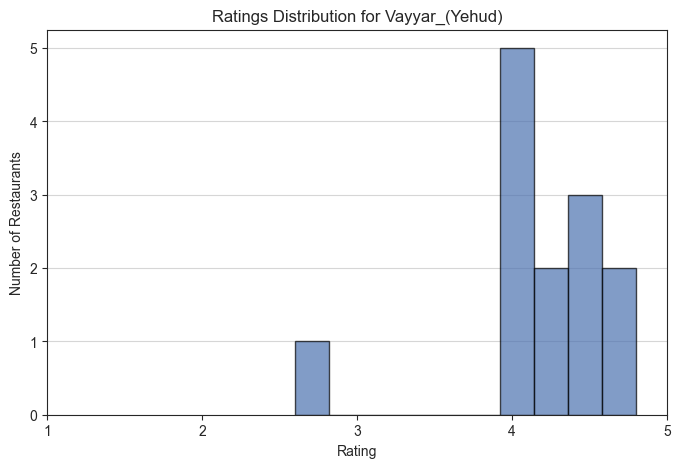

In [8]:
workareas = filtered_df["workarea"].unique()

for workarea in workareas:
    ratings = filtered_df[filtered_df["workarea"] == workarea]["rating"]

    plt.figure(figsize=(8, 5))
    plt.hist(ratings, bins=10, color="#4C72B0", edgecolor="black", alpha=0.7)
    plt.title(f"Ratings Distribution for {workarea}")
    plt.xlabel("Rating")
    plt.ylabel("Number of Restaurants")
    plt.xticks([1, 2, 3, 4, 5])
    plt.grid(axis="y", alpha=0.8)
    plt.show()

## Draw huge histogram of all places

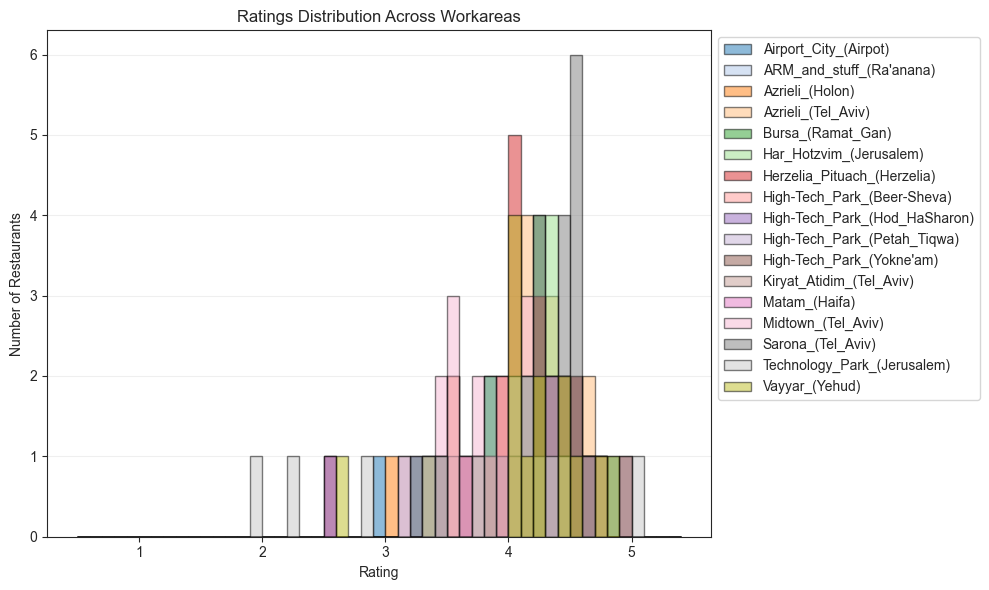

In [9]:
workareas = filtered_df["workarea"].unique()
colors = plt.cm.tab20.colors

plt.figure(figsize=(10, 6))

for idx, workarea in enumerate(workareas):
    ratings = filtered_df[filtered_df["workarea"] == workarea]["rating"]
    plt.hist(
        ratings,
        bins=np.arange(0.5, 5.5, 0.1),
        alpha=0.5,
        label=workarea,
        color=colors[idx % len(colors)],
        edgecolor="black"
    )

plt.xlabel("Rating")
plt.ylabel("Number of Restaurants")
plt.title("Ratings Distribution Across Workareas")
plt.xticks([1, 2, 3, 4, 5])
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Compare selected places to show center > not center

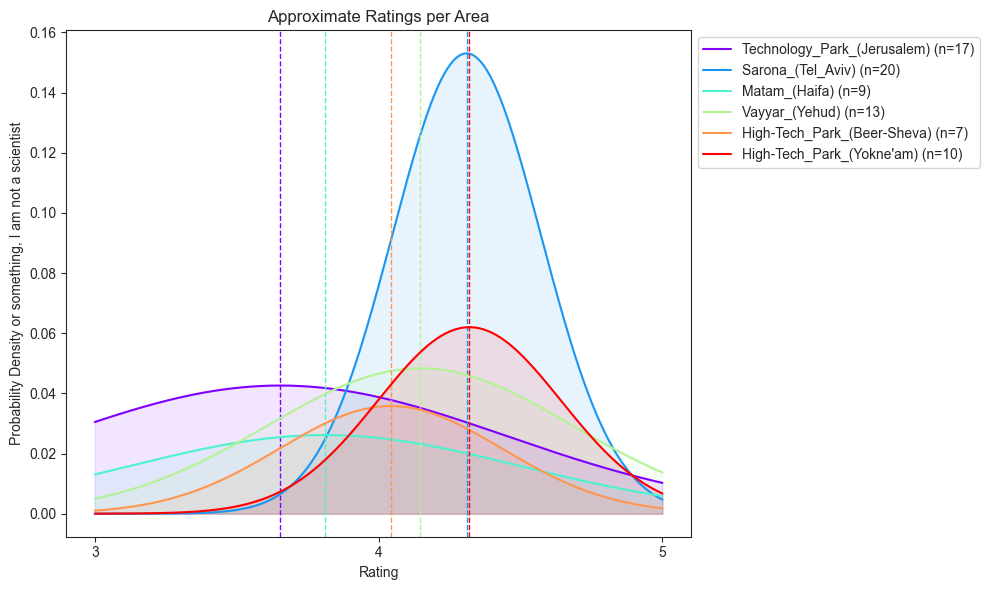

In [22]:
workareas = ["Technology_Park_(Jerusalem)",
             "Sarona_(Tel_Aviv)",
             "Matam_(Haifa)",
             "Vayyar_(Yehud)",
             "High-Tech_Park_(Beer-Sheva)",
             "High-Tech_Park_(Yokne'am)"]

colors = plt.cm.rainbow(np.linspace(0, 1, len(workareas)))
plt.figure(figsize=(10, 6))

x = np.linspace(3, 5, 400)

for idx, workarea in enumerate(workareas):
    group = filtered_df[filtered_df["workarea"] == workarea]["rating"]
    mean = group.mean()
    std = group.std()

    y = stats.norm.pdf(x, loc=mean, scale=std)

    y_scaled = y * len(group) * (x[1] - x[0])

    plt.plot(x, y_scaled, label=f"{workarea} (n={len(group)})", color=colors[idx % len(colors)])
    plt.fill_between(x, 0, y_scaled, alpha=0.1, color=colors[idx % len(colors)])
    plt.axvline(mean, color=colors[idx % len(colors)], linestyle="--", linewidth=1)

plt.xlabel("Rating")
plt.ylabel("Probability Density or something, I am not a scientist")
plt.title("Approximate Ratings per Area")
plt.xticks([3, 4, 5])
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


## Created weighted scores adjusted for distance to restaurant

In [18]:
adjusted_df = filtered_df.groupby("workarea").apply(compute_adjusted_score_within_workarea)
adjusted_df = adjusted_df.reset_index(drop=True)  # removes the index added by groupby.apply

avg_scores = adjusted_df.groupby("workarea")["adjusted_score"].mean().sort_values(ascending=False)
workarea_order = avg_scores.index.tolist()

C:\Users\Bulgarit\AppData\Local\Temp\ipykernel_3556\4216423337.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adjusted_df = filtered_df.groupby("workarea").apply(compute_adjusted_score_within_workarea)


C:\Users\Bulgarit\AppData\Local\Temp\ipykernel_3556\1475874312.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
C:\Users\Bulgarit\AppData\Local\Temp\ipykernel_3556\1475874312.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


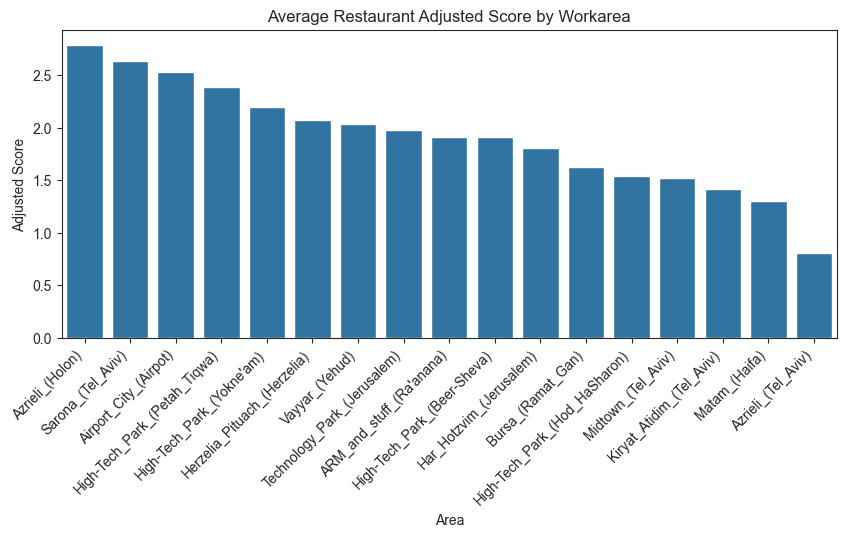

In [21]:
sns.set_style("ticks")
plt.figure(figsize=(10, 4))
ax = sns.barplot(
    x="workarea",
    y="adjusted_score",
    data=adjusted_df,
    order=workarea_order,
    ci=None
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.title("Average Restaurant Adjusted Score by Workarea")
plt.xlabel("Area")
plt.ylabel("Adjusted Score")
plt.show()